<h1 align=center><font size = 10>ASM 1</font></h1>

# Bài toán

Trong notebook này, chúng ta sẽ ứng dụng thuật toán hồi quy tuyến tính mà chúng ta đã học trong khóa học này.

Hãy đọc dữ liệu bằng thư viện Pandas, sau đó sử dụng thuật toán hồi quy tuyến tính với các đặc trưng khác nhau nhằm tìm ra thuật toán hồi quy tuyến tính tốt nhất thông qua phương pháp đánh giá độ chính xác.

Tập dữ liệu và bài toán thuộc dạng hồi quy cổ điển. Với một số đặc trưng nhất định, chúng ta cần xây dựng một mô hình hồi quy tuyến tính để xác định **số lượng hồ sơ được chấp nhận** dựa vào các đặc trưng đã có.

Để giải quyết bài toán này, chúng ta cần phân tích dữ liệu, thực hiện bất kỳ chuyển đổi và chuẩn hóa cần thiết nào, áp dụng thuật toán ML, huấn luyện mô hình, kiểm tra chất lượng của mô hình đã huấn luyện và lặp lại cho đến khi có được chất lượng cao nhất cho tập dữ liệu của mình.

# Pipeline

1. Đọc dữ liệu.

2. Tiền xử lý dữ liệu.

3. Trực quan dữ liệu.

4. Chuẩn bị dữ liệu.

5. Xây dựng mô hình hồi quy tuyến tính đơn biến.

6. Xây dựng mô hình hồi quy tuyến tính đa biến.

7. Xây dựng mô hình hồi quy tuyến tính trên toàn bộ đặc trưng để quan sát mối quan hệ giữa các đặc trưng và mục tiêu.

8. Xây dựng mô hình Lasso để lựa chọn đặc trưng tốt nhất cho mục tiêu.

# Tập dữ liệu

Dự án này liên quan đến tập dữ liệu College, trong file [College.csv](https://drive.google.com/file/d/167ysw5-Bf15_Gm_aiePZfrS3fBWWfJVl/view) trong thư mục dữ liệu. Nó chứa các biến sau cho 777 trường đại học và cao đẳng khác nhau ở Mỹ:

**Private**: Chỉ báo public/private

**Apps**: Số lượng hồ sơ nhận được

**Accept**: Số lượng sinh viên được chấp thuận

**Enroll**: Số sinh viên mới đăng ký

**Top10perc**: Sinh viên mới từ top 10% lớp trung học

**Top25perc**: Sinh viên mới từ top 25% lớp trung học

**F.Undergrad**: Số sinh viên đại học toàn thời gian

**P.Undergrad**: Số sinh viên đại học bán thời gian

**Outstate**: Học phí ngoại bang

**Room.Board**: Chi phí ăn ở

**Books**: Chi phí giáo trình theo ước tính

**Personal**: Chi tiêu cá nhân theo ước tính

**PhD**: Phần trăm giảng viên có bằng Tiến sĩ

**Terminal**: Phần trăm giảng viên có Terminal degree (bẳng cấp cao nhất trong một lĩnh vực nhất định)

**S.F.Ratio**: Tỷ lệ sinh viên/giảng viên

**perc.alumni**: Phần trăm cựu sinh viên đã quyên góp

**Expend**: Chi phí giảng dạy cho mỗi sinh viên

**Grad.Rate**: Tỷ lệ tốt nghiệp

In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

plt.style.use('ggplot')

# Hàm tiện ích

Phương pháp tiện ích này sẽ giúp vẽ biểu đồ các quan sát thử nghiệm của bạn, so sánh chúng với đường hồi quy và hiển thị hệ số R2.

In [3]:
def drawLine(model,x_test,y_test,title):
    # Hàm vẽ biểu đồ hồi quy khi X_test có 1 đặc trưng
    # và hiển thị hệ số R2
    y_pred = model.predict(x_test)

    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    ax.scatter(x_test,y_test,c= 'g')
    ax.plot(x_test,y_pred,alpha = 0.7, color = 'r', linewidth = 1)
    R2 = r2_score(y_pred,y_test)

    ax.set_title(title)
    print('R2 score: '+ str(R2))
    print('intercept: ', model.intercept_)
    plt.show()



In [4]:
def drawPlane(model, X_test, y_test, title):
    # Hàm vẽ biểu đồ hồi quy khi X_test có 2 đặc trưng
    # và hiển thị hệ số R2
    fig = plt.figure()
    ax = Axes3D(fig)
    ax.set_zlabel('prediction')

    
    # Chuyển về numpy vì X_test có thể là DataFrame, v.v.
    X_test = np.array(X_test)
    col1 = X_test[:,0]
    col2 = X_test[:,1]

    
    # Lấy giá trị nhỏ nhất và lớn nhất của 2 đặc trưng
    # để vẽ siêu mặt phẳng   
    # do điểm nhỏ nhất và lớn nhất sẽ bao bọc toàn bộ dữ liệu
    x_min, x_max = col1.min(), col1.max()
    y_min, y_max = col2.min(), col2.max()
    x = np.arange(x_min, x_max, (x_max-x_min) / 10)
    y = np.arange(y_min, y_max, (y_max-y_min) / 10)
    x, y = np.meshgrid(x, y)

    
    # Dự đoán để lấy siêu mặt phẳng
    z = model.predict(np.c_[x.ravel(), y.ravel()])
    z = z.reshape(x.shape)

    # Trực quan hóa dữ liệu và vẽ siêu mặt phẳng
    ax.scatter(col1, col2, y_test, c='g', marker='o')
    ax.plot_wireframe(x, y, z, color='orange', alpha=0.7)
    
    y_pred = model.predict(X_test)
    R2 = r2_score(y_test, y_pred)

    ax.set_title(title)
    print("R2: " + str(R2))
    print("Intercept(s): ", model.intercept_)

    plt.show()

# Task 1: Đọc dữ liệu từ tập dữ liệu College

Chỉ mục là cột tên trường đại học.

In [5]:
df = pd.read_csv("College.csv",index_col=0)
df.head()

,Private,Apps,Accept,Enroll,Top10perc,Top25perc,F.Undergrad,P.Undergrad,Outstate,Room.Board,Books,Personal,PhD,Terminal,S.F.Ratio,perc.alumni,Expend,Grad.Rate
Abilene Christian University,Yes,1660,1232,721,23,52,2885,537,7440,3300,450,2200,70,78,18.1,12,7041,60
Adelphi University,Yes,2186,1924,512,16,29,2683,1227,12280,6450,750,1500,29,30,12.2,16,10527,56
Adrian College,Yes,1428,1097,336,22,50,1036,99,11250,3750,400,1165,53,66,12.9,30,8735,54
Agnes Scott College,Yes,417,349,137,60,89,510,63,12960,5450,450,875,92,97,7.7,37,19016,59
Alaska Pacific University,Yes,193,146,55,16,44,249,869,7560,4120,800,1500,76,72,11.9,2,10922,15


# Task 2: Mã hóa hạng mục 

Sử dụng map() để chuyển đổi cột Private thành {'Yes':1, 'No':0}.

Hầu hết tất cả thuật toán học máy đều không làm việc với dữ liệu chuỗi hoặc hạng mục, do đó cần chuyển đổi những loại dữ liệu này để phù hợp với đầu vào của học máy. Phương thức `.map()` giống như `.apply()`, nhưng thay vì sử dụng lambda/function, bạn chỉ cần cung cấp ánh xạ key:value.

In [6]:
def convert(key):
    if key == 'Yes': return 1
    else: return 0

In [7]:
df['Private'] = df['Private'].apply(convert)

In [8]:
df.head()

,Private,Apps,Accept,Enroll,Top10perc,Top25perc,F.Undergrad,P.Undergrad,Outstate,Room.Board,Books,Personal,PhD,Terminal,S.F.Ratio,perc.alumni,Expend,Grad.Rate
Abilene Christian University,1,1660,1232,721,23,52,2885,537,7440,3300,450,2200,70,78,18.1,12,7041,60
Adelphi University,1,2186,1924,512,16,29,2683,1227,12280,6450,750,1500,29,30,12.2,16,10527,56
Adrian College,1,1428,1097,336,22,50,1036,99,11250,3750,400,1165,53,66,12.9,30,8735,54
Agnes Scott College,1,417,349,137,60,89,510,63,12960,5450,450,875,92,97,7.7,37,19016,59
Alaska Pacific University,1,193,146,55,16,44,249,869,7560,4120,800,1500,76,72,11.9,2,10922,15


# Task 3: Trực quan ma trận tương quan

Text(0.5, 1.05, '"Correlation coefficients matrix')

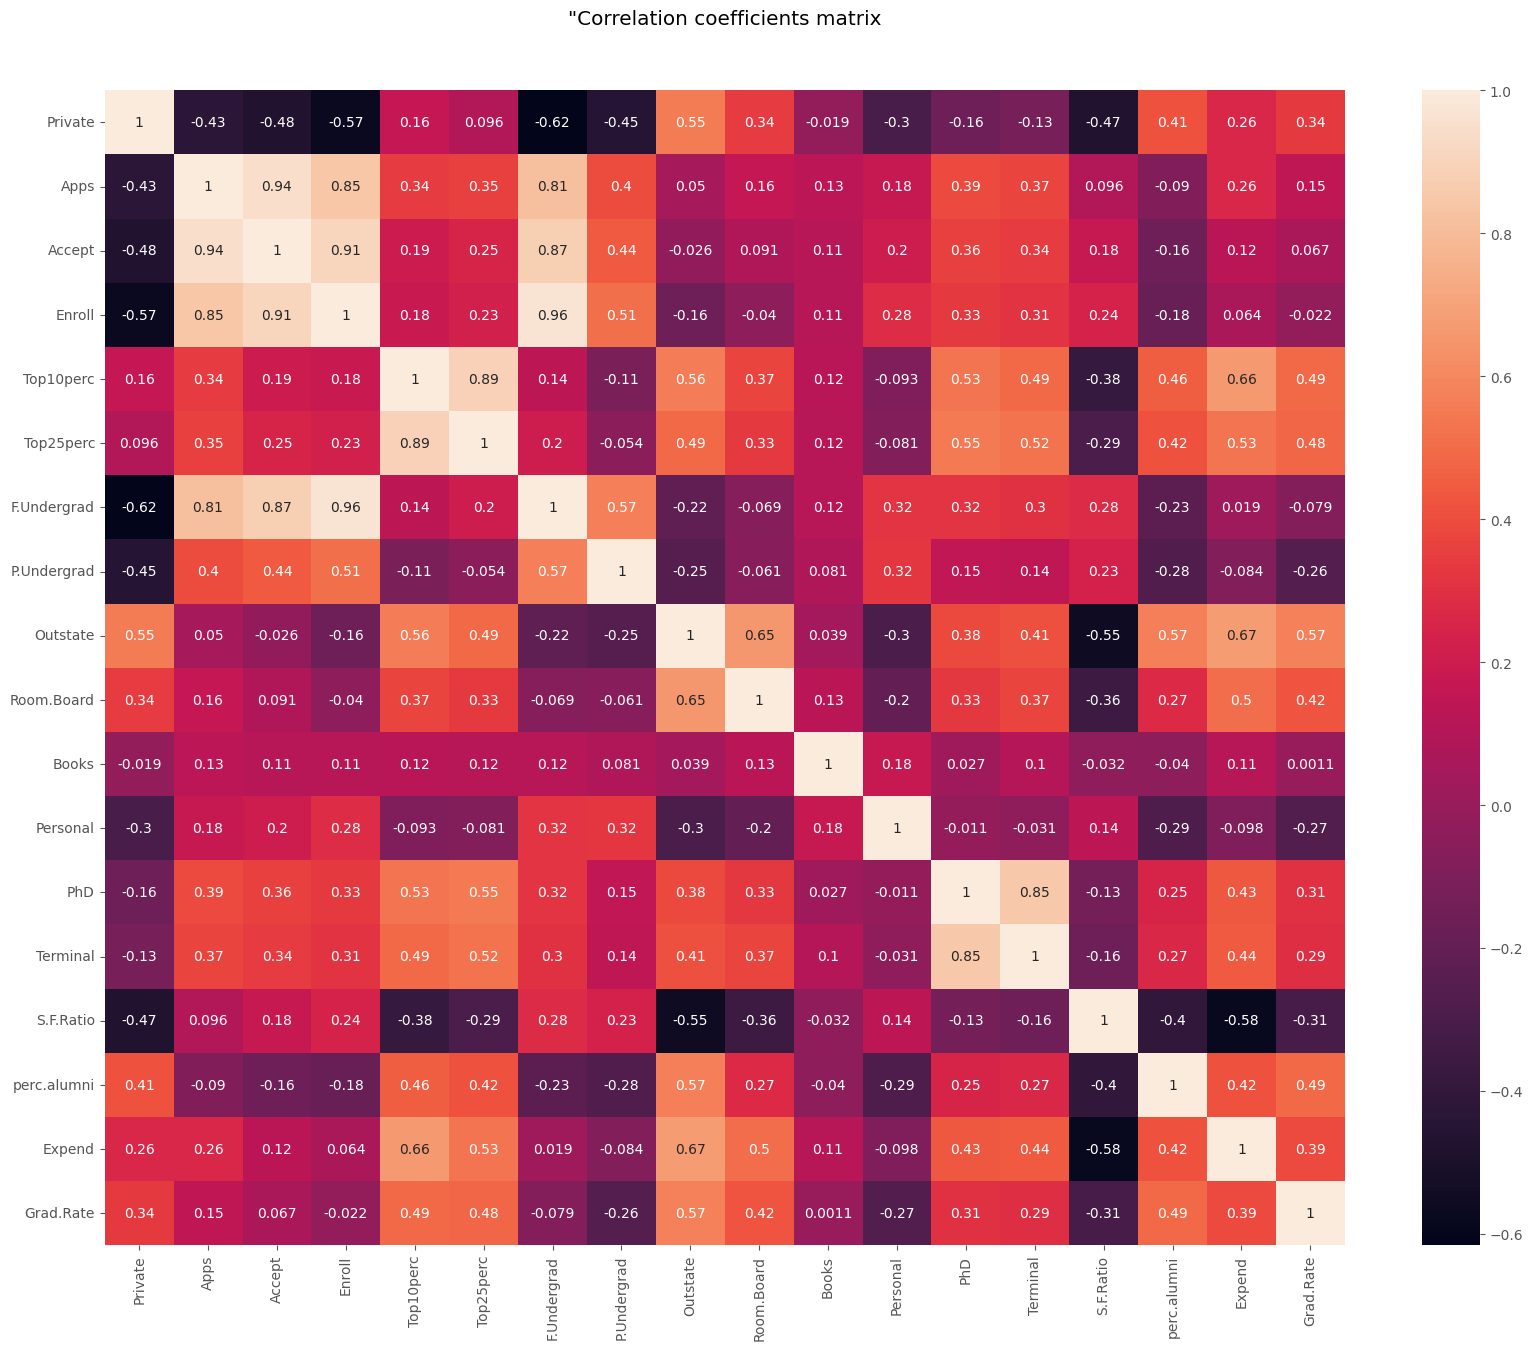

In [9]:
plt.figure(figsize = (20,15))
sns.heatmap(df.corr(),annot = True)
plt.title('"Correlation coefficients matrix', y = 1.05)

# Task 4: Vẽ biểu đồ Scatter từng đặc trưng với mục tiêu

Lấy ra toàn bộ đặc trưng từ dữ liệu và loại bỏ đi mục tiêu ("Accept")

In [10]:
df_2 = df.drop('Accept',axis = 1)

In [11]:
columns = np.array(df_2.columns)

In [12]:
columns

array(['Private', 'Apps', 'Enroll', 'Top10perc', 'Top25perc',
       'F.Undergrad', 'P.Undergrad', 'Outstate', 'Room.Board', 'Books',
       'Personal', 'PhD', 'Terminal', 'S.F.Ratio', 'perc.alumni',
       'Expend', 'Grad.Rate'], dtype=object)

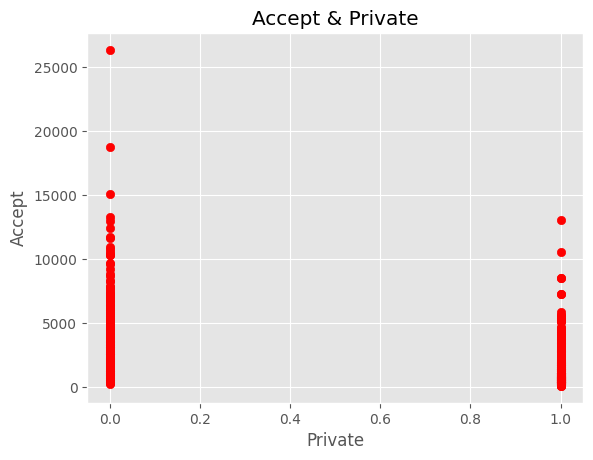

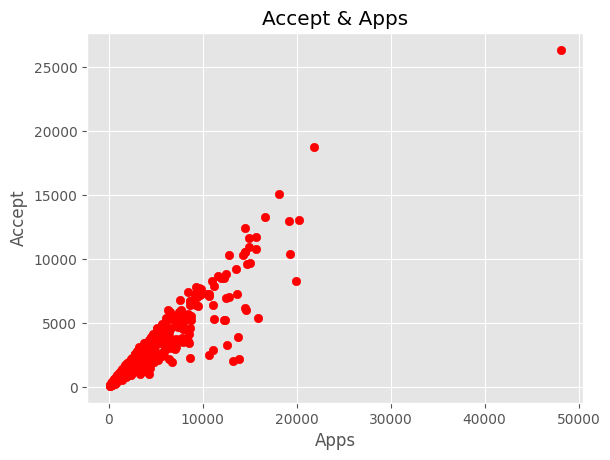

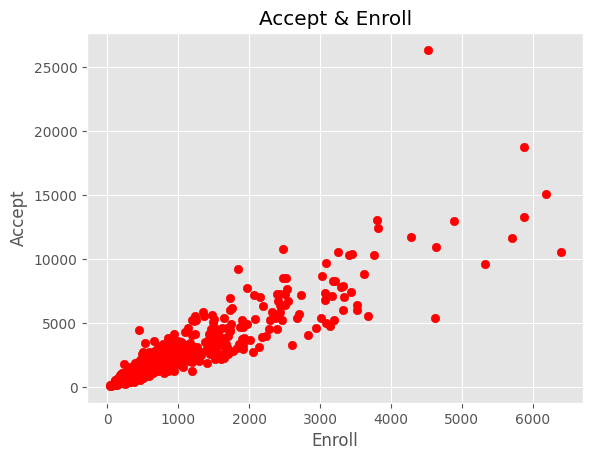

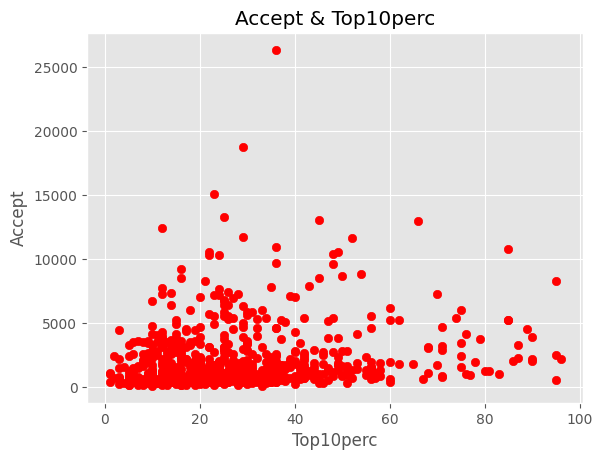

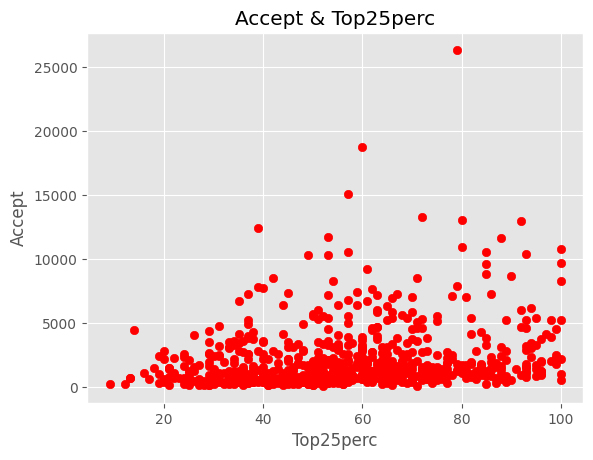

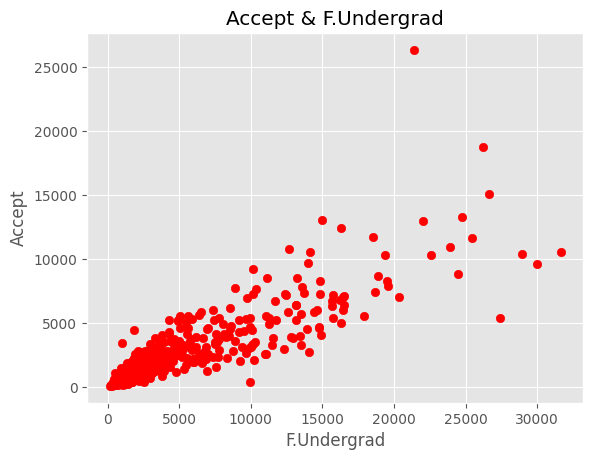

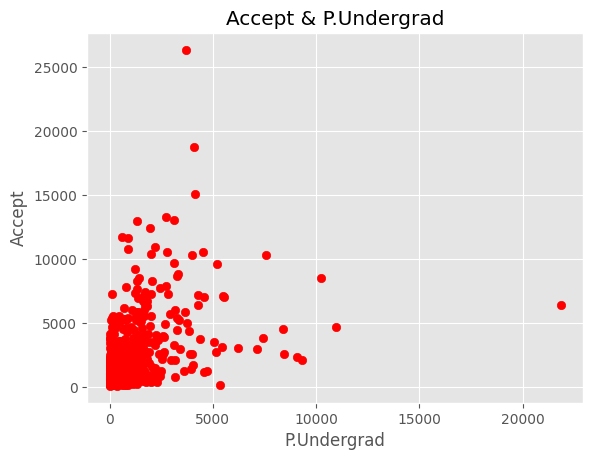

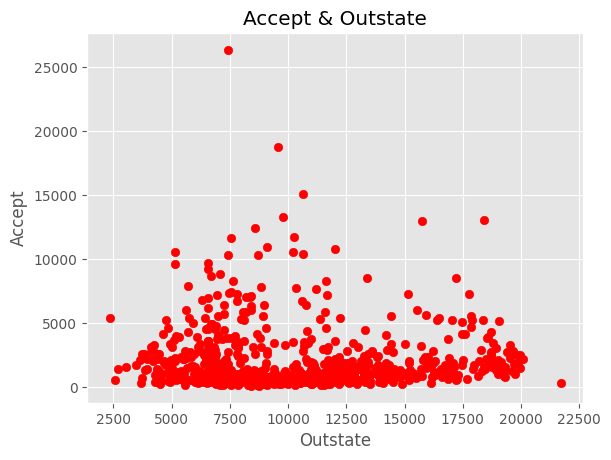

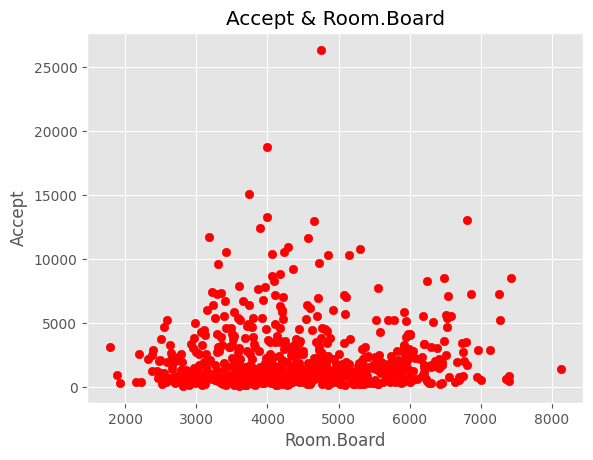

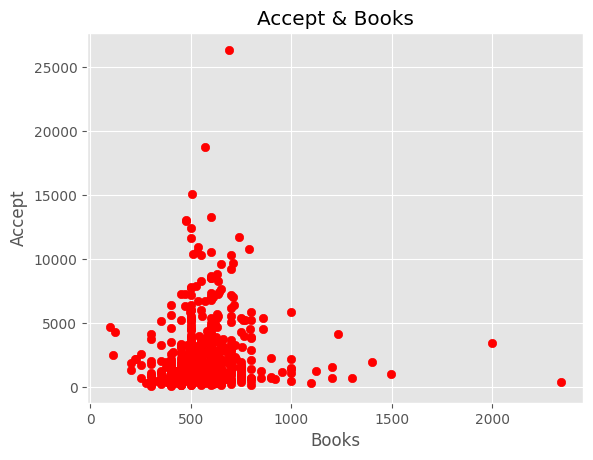

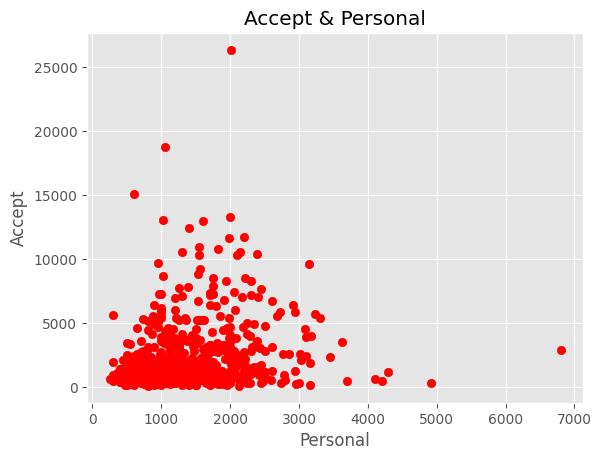

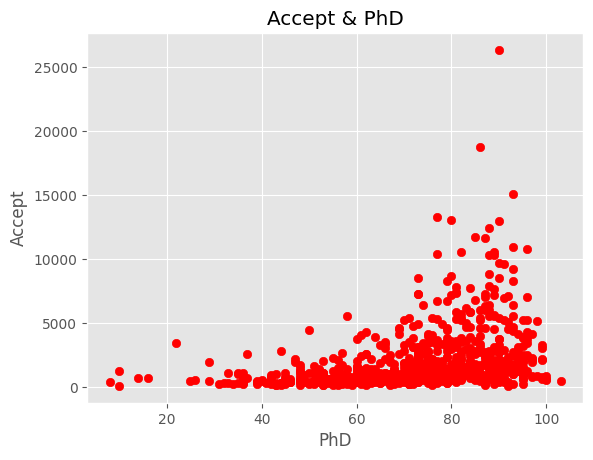

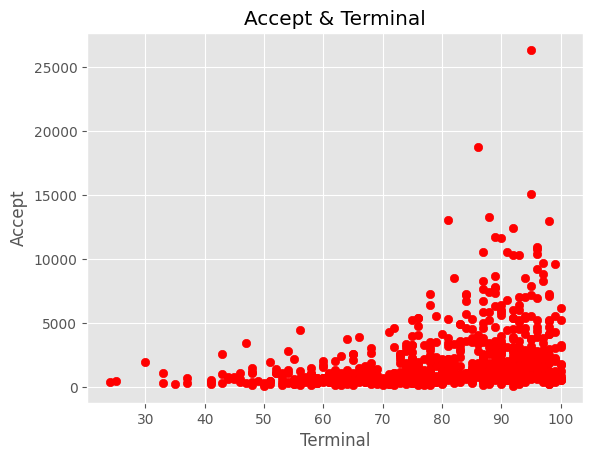

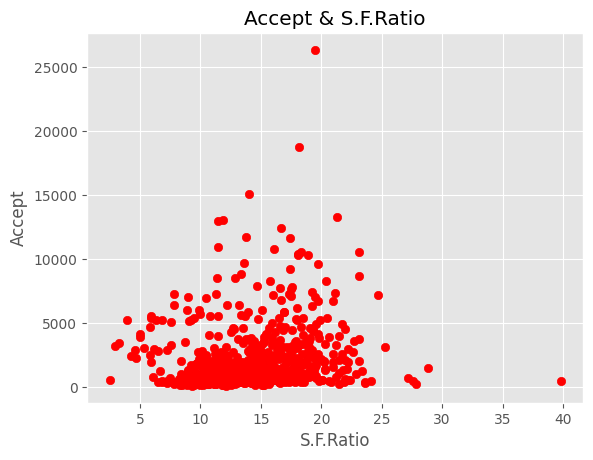

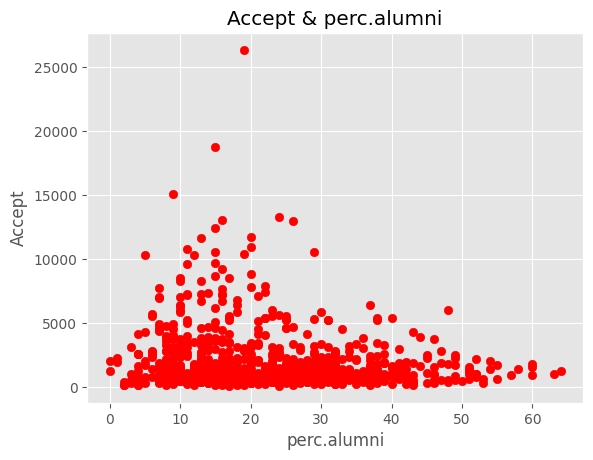

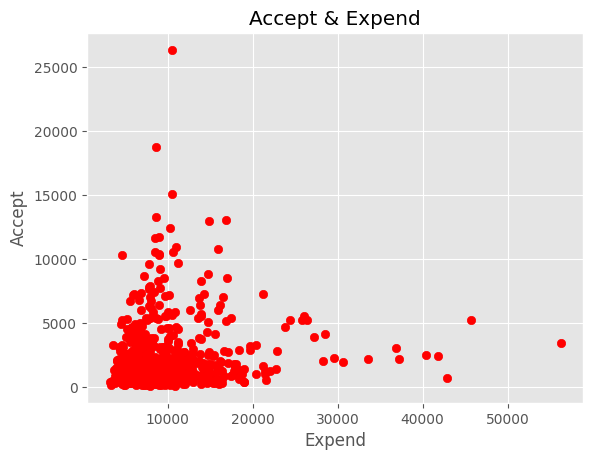

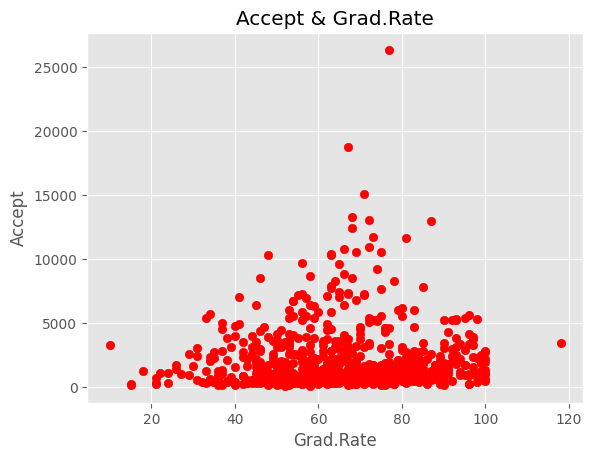

In [13]:
for it in columns:
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.scatter(df_2[it],df['Accept'], color = 'red')
    ax.set_xlabel(it)
    ax.set_ylabel('Accept')
    ax.set_title('Accept & '+ it)

# Task 5: Phân tách dữ liệu đặc trưng vào X, dữ liệu mục tiêu vào y từ dữ liệu gốc


In [14]:
x = df[columns]
y = df['Accept']
x.head()

,Private,Apps,Enroll,Top10perc,Top25perc,F.Undergrad,P.Undergrad,Outstate,Room.Board,Books,Personal,PhD,Terminal,S.F.Ratio,perc.alumni,Expend,Grad.Rate
Abilene Christian University,1,1660,721,23,52,2885,537,7440,3300,450,2200,70,78,18.1,12,7041,60
Adelphi University,1,2186,512,16,29,2683,1227,12280,6450,750,1500,29,30,12.2,16,10527,56
Adrian College,1,1428,336,22,50,1036,99,11250,3750,400,1165,53,66,12.9,30,8735,54
Agnes Scott College,1,417,137,60,89,510,63,12960,5450,450,875,92,97,7.7,37,19016,59
Alaska Pacific University,1,193,55,16,44,249,869,7560,4120,800,1500,76,72,11.9,2,10922,15


In [15]:
y.head()

Abilene Christian University    1232
Adelphi University              1924
Adrian College                  1097
Agnes Scott College              349
Alaska Pacific University        146
Name: Accept, dtype: int64

# Task 6: Tách dữ liệu thành train/test data

Dữ liệu train chiếm 70% và random_state là 7.

In [16]:
from sklearn.model_selection import train_test_split

In [17]:
x_train, x_test, y_train, y_test = train_test_split(x,y,train_size = 0.7,test_size = 0.3,random_state = 7)

# Task 7: Mô hình hóa hồi quy tuyến tính chi phí ăn ở và số lượng sinh viên được chấp nhận và trực quan mô hình

Tách dữ liệu chi phí ăn ở từ bộ train và test

In [18]:
y_train_rb = np.array(y_train).reshape(-1,1)
y_test_rb = np.array(y_test).reshape(-1,1)

Điều chỉnh shape dữ liệu phù hợp với đầu vào của mô hình

Mô hình hồi quy tuyến tính yêu cầu đầu vào có dạng là (m, n) với X và (m, 1) với y.

Trong đó:

- m là số lượng mẫu quan sát

- n là số lượng đặc trưng

Với một đặc trưng duy nhất, shape phù hợp sẽ là (m, 1) cho X.

In [19]:
model_1 = LinearRegression()
model_1.fit(np.array(x_train['Room.Board']).reshape(-1,1),y_train_rb)

LinearRegression()

In [20]:
y_pred = model_1.predict(np.array(x_test['Room.Board']).reshape(-1,1))

In [21]:
r2_score(y_test_rb,y_pred)

-0.0026669864145500988

Text(0.5, 1.0, 'Room.Board')

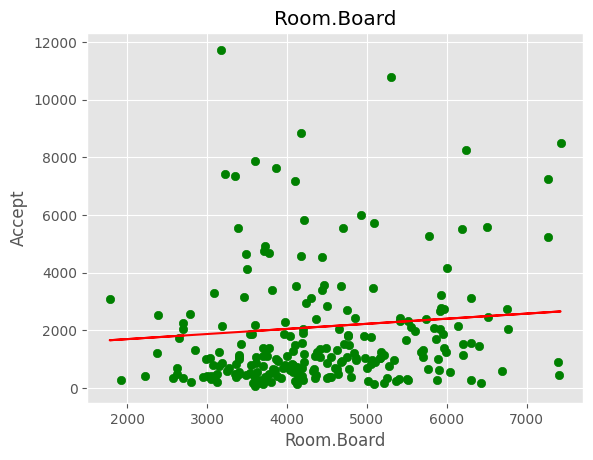

In [22]:
plt.scatter(x_test['Room.Board'],y_test,c = 'g')
plt.plot(x_test['Room.Board'],y_pred,c = 'red')
plt.xlabel('Room.Board')
plt.ylabel('Accept')
plt.title('Room.Board')


# Task 8: Mô hình hóa hồi quy tuyến tính số lượng sinh viên ghi danh cho mỗi trường đại học và số lượng sinh viên được chấp nhận và trực quan mô hình

Tách dữ liệu số lượng sinh viên ghi danh cho mỗi trường đại học ở từ bộ train và test

In [23]:
model_2= LinearRegression()
model_2.fit(np.array(x_train['Enroll']).reshape(-1,1),y_train_rb)

LinearRegression()

In [24]:
y_pred = model_2.predict(np.array(x_test['Enroll']).reshape(-1,1))

In [25]:
r2_score(y_pred,y_test)

0.8446325925803302

Text(0.5, 1.0, 'Room.Board')

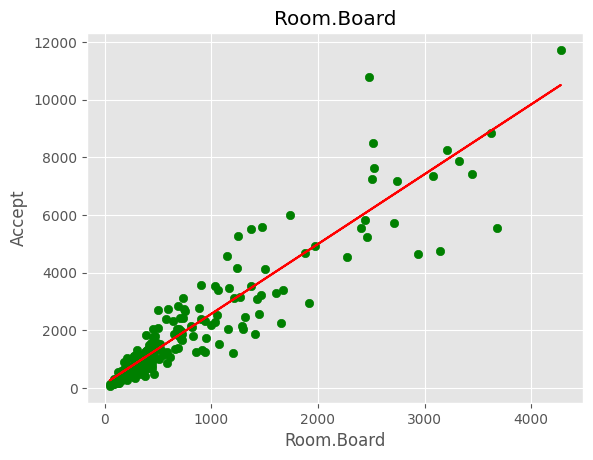

In [26]:
plt.scatter(x_test['Enroll'],y_test,c = 'g')
plt.plot(x_test['Enroll'],y_pred,c = 'red')
plt.xlabel('Room.Board')
plt.ylabel('Accept')
plt.title('Room.Board')

# Task 9: Mô hình hóa hồi quy tuyến tính từng đặc trưng với số lượng sinh viên được chấp nhận và trực quan hóa mô hình với dữ liệu test

Lưu ý: Sử dụng vòng lặp

R2 score: -1.147495886338194
intercept:  4082.934210526321


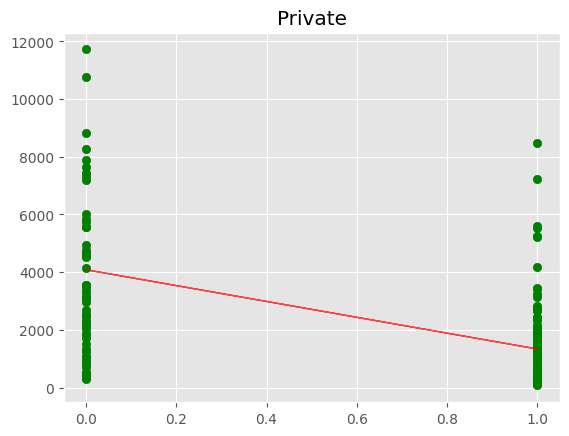

R2 score: 0.8314320432524063
intercept:  215.66921083593638


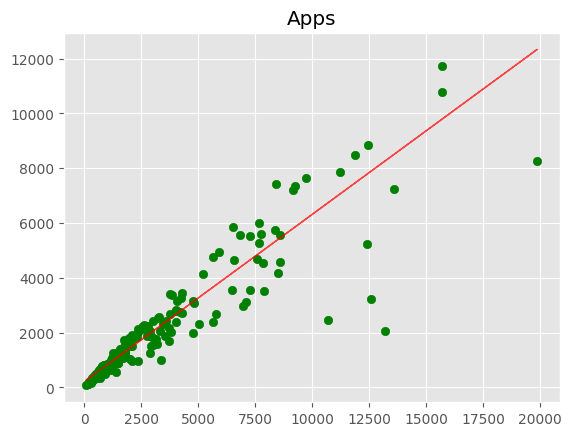

R2 score: 0.8446325925803302
intercept:  151.7261124227632


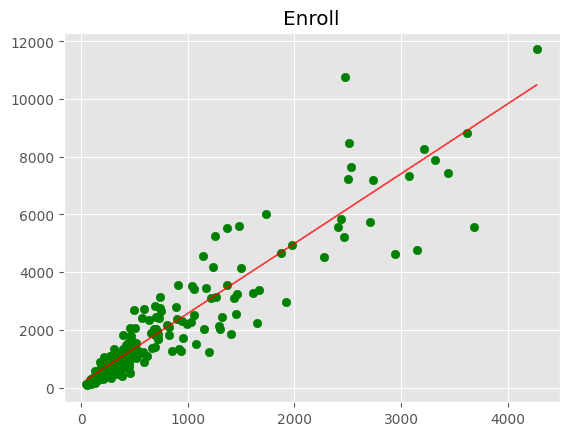

R2 score: -13.261329838225192
intercept:  1397.3784275961889


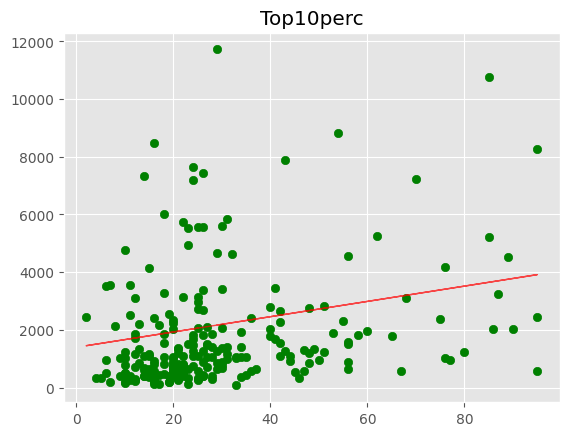

R2 score: -9.446981491253007
intercept:  378.8846828301889


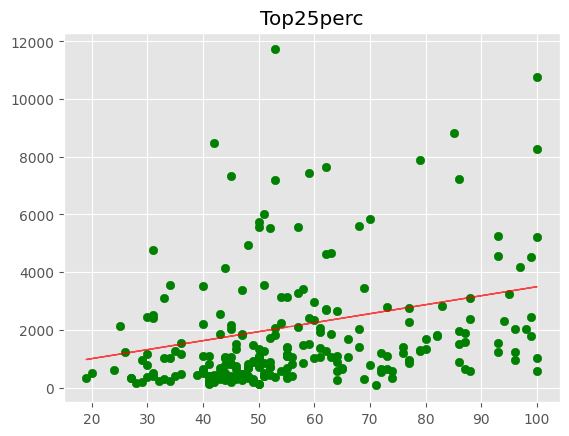

R2 score: 0.74965059456651
intercept:  380.94291049842764


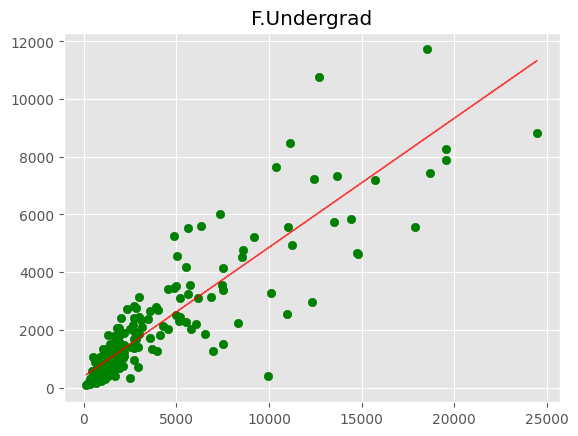

R2 score: -2.123644584021602
intercept:  1444.348151749116


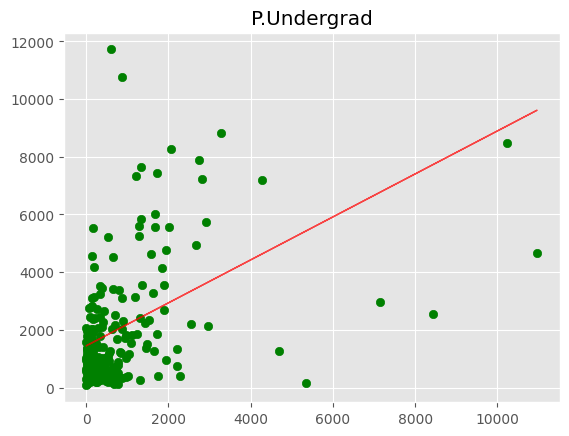

R2 score: -196.3474864685928
intercept:  2472.297811569735


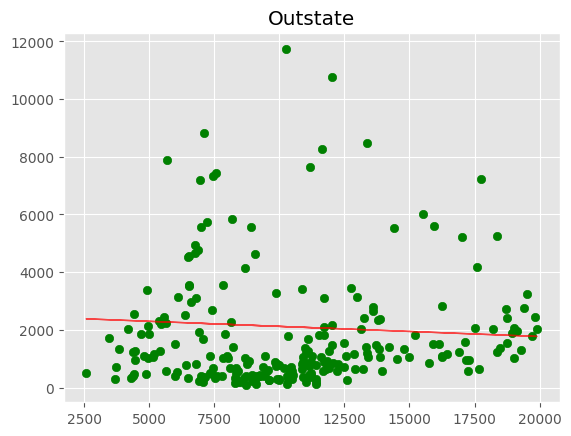

R2 score: -98.75889478130017
intercept:  1340.619565189838


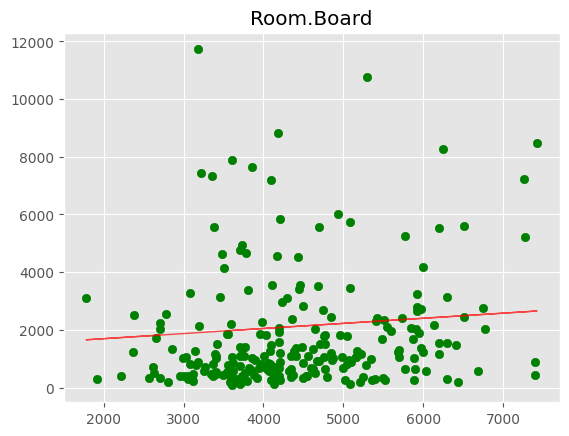

R2 score: -52.18189978931753
intercept:  1304.8355956198193


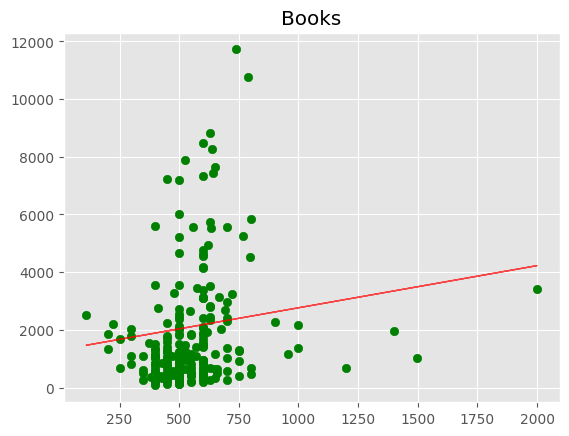

R2 score: -19.794857843214654
intercept:  1185.975607940944


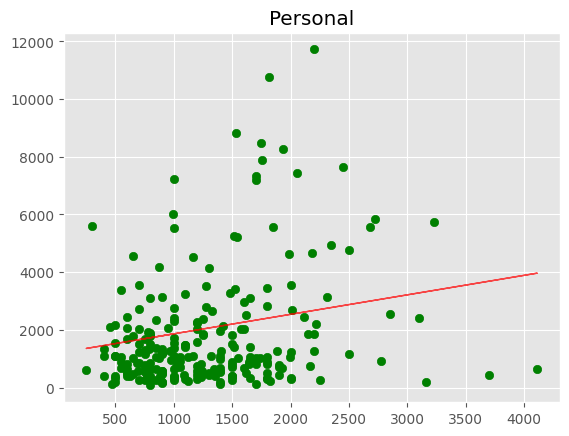

R2 score: -3.114805046231786
intercept:  -1901.7356825532374


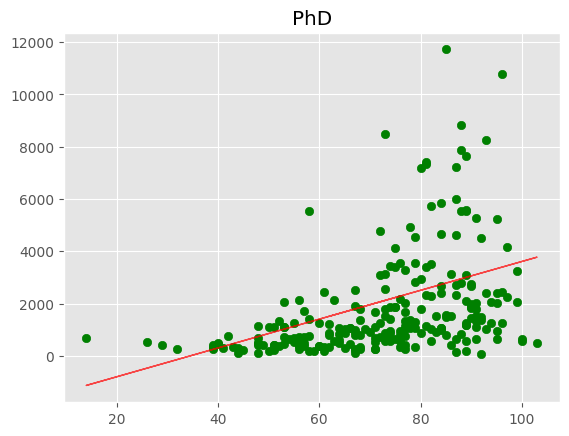

R2 score: -3.907835198749644
intercept:  -2566.341123006579


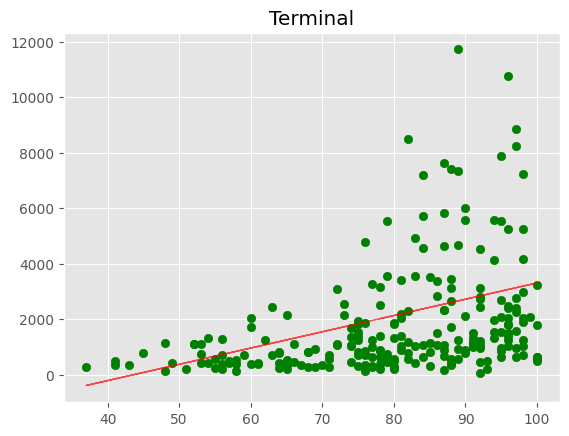

R2 score: -19.500942976087703
intercept:  406.0892030188854


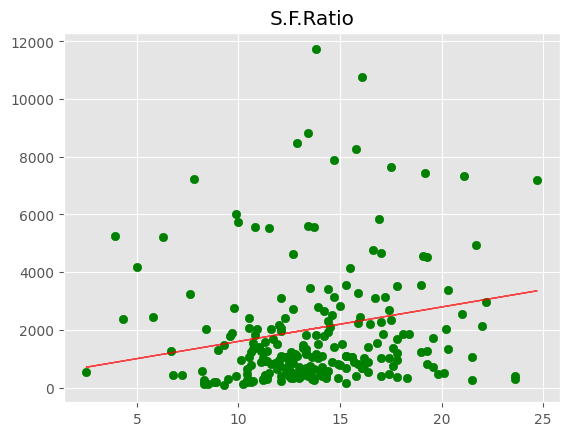

R2 score: -20.366624091425372
intercept:  2869.319570792186


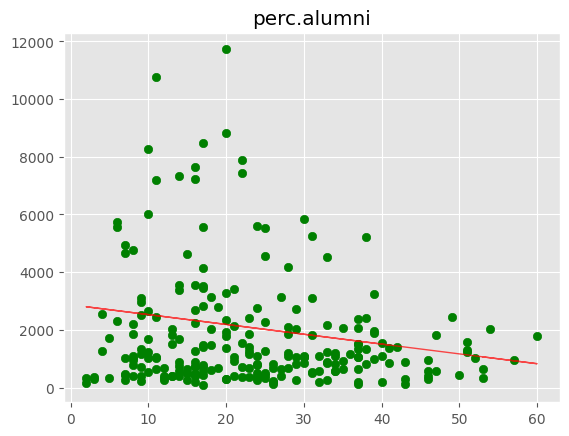

R2 score: -55.52477241121407
intercept:  1652.5167772242703


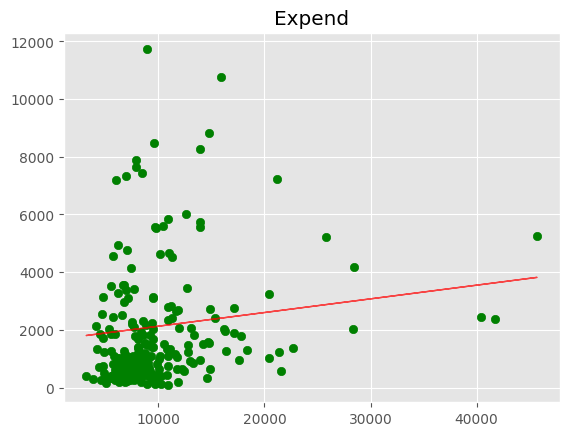

R2 score: -115.4366149447513
intercept:  1407.4974601852537


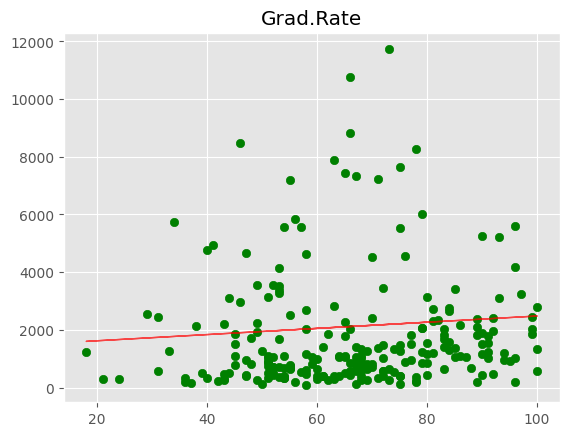

In [27]:
for it in columns:
    model = LinearRegression()
    x_train_ = x_train[[it]]
    model.fit(x_train_,y_train)
    x_test_ = x_test[[it]]
    drawLine(model,x_test_,y_test,it)
    
    

# Task 10: Mô hình hóa hồi quy tuyến đa biến số lượng sinh viên ghi danh cho mỗi trường đại học và chi phí ăn ở để dự đoán số lượng sinh viên được chấp nhận và trực quan mô hình

Tách dữ liệu số lượng sinh viên ghi danh cho mỗi trường đại học và chi phí ăn ở từ bộ train và test

In [28]:
x_train_rb = x_train[['Enroll','Room.Board']]
x_test_rb = x_test[['Enroll','Room.Board']]

In [29]:
x_test.head()

,Private,Apps,Enroll,Top10perc,Top25perc,F.Undergrad,P.Undergrad,Outstate,Room.Board,Books,Personal,PhD,Terminal,S.F.Ratio,perc.alumni,Expend,Grad.Rate
Westminster College,1,996,377,29,58,1411,72,12065,3615,430,685,62,78,12.5,41,8596,80
North Central College,1,1127,308,30,64,1310,766,11718,7398,450,1800,73,87,16.4,33,8871,76
Dominican College of Blauvelt,1,360,108,4,19,756,863,8310,5500,600,1800,43,43,12.7,5,5480,54
Baldwin-Wallace College,1,1690,662,30,61,2718,1460,10995,4410,1000,1000,68,74,17.6,20,8086,85
SUNY College at Geneseo,0,8598,1143,56,93,5060,146,6550,4170,600,650,79,84,19.1,25,5716,76


Điều chỉnh shape phù hợp với đầu vào của mô hình. 

Lưu ý dữ liệu của chúng ta ở phần này là 2 đặc trưng, do đó đầu vào của mô hình đối với X sẽ là (m, 2)

In [30]:
model_3 = LinearRegression()
model_3.fit(x_train_rb,y_train)

LinearRegression()

In [31]:
y_pred = model_3.predict(x_test_rb)
r2_score(y_pred,y_test)

0.8716631742505863

In [32]:
drawPlane(model_3,x_test_rb,y_test,'Enroll and Room.Board')

R2: 0.8764371774214047
Intercept(s):  -1176.6284824940835


C:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


<Figure size 640x480 with 0 Axes>

# Task 11: Sử dụng hồi quy tuyến tính với toàn bộ đặc trưng để quan sát tác động của từng đặc trưng đến mục tiêu

Tạo một bản sao về dữ liệu train và test

In [41]:
from sklearn.preprocessing import StandardScaler

In [53]:
x_train_cp = x_train
x_test_cp= x_test
y_test_cp = np.array(y_test).reshape(-1,1)
y_train_cp = np.array(y_train).reshape(-1,1)

In [55]:
x_train_cp

,Private,Apps,Enroll,Top10perc,Top25perc,F.Undergrad,P.Undergrad,Outstate,Room.Board,Books,Personal,PhD,Terminal,S.F.Ratio,perc.alumni,Expend,Grad.Rate
Illinois Wesleyan University,1,3050,471,55,86,1818,23,14360,4090,400,650,77,92,12.9,34,9605,83
Point Park College,1,875,207,7,38,1173,1402,9700,4830,400,1200,45,90,14.5,10,7652,66
Colorado State University,0,9478,2194,29,65,15646,1829,8412,4180,470,1800,87,89,19.2,10,7850,59
Spring Arbor College,1,372,181,15,32,1501,353,8600,3550,385,665,48,48,15.4,9,10938,49
University of Rochester,1,8766,1243,56,75,5071,438,17840,6582,500,882,93,99,5.9,23,26037,80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Taylor University,1,1769,437,41,80,1757,81,10965,4000,450,1250,60,61,14.2,32,8294,98
Saint Olaf College,1,2248,745,38,73,2888,105,14350,3750,550,550,82,88,10.0,31,12502,83
Southwest State University,0,1047,511,13,33,2091,546,4285,2750,600,1800,58,75,16.5,31,6591,51
Fairfield University,1,4784,781,30,66,2984,1037,15000,6200,700,1100,86,90,15.1,30,11220,94


Điều chỉnh shape phù hợp với đầu vào của mô hình.

Lưu ý rằng đầu vào của mô hình lúc này sẽ là (m, n).

In [65]:
scaler = StandardScaler()
x_train_cp = scaler.fit_transform(x_train_cp)
x_test_cp= scaler.fit_transform(x_test_cp)
y_test_cp = scaler.fit_transform(y_test_cp)
y_train_cp = scaler.fit_transform(y_train_cp)

In [66]:
model_4 = LinearRegression()
model_4.fit(x_train_cp,y_train_cp)

LinearRegression()

In [67]:
y_pred = model_4.predict(x_test_cp)

In [69]:
print('R2 score: ',r2_score(y_pred,y_test_cp))

R2 score:  0.9187622513120125


In [70]:
model_4.coef_

array([[ 0.03299418,  0.68335993,  0.44562369, -0.19019004,  0.05845354,
        -0.05856631, -0.02193362,  0.10372985, -0.00462638, -0.00190923,
        -0.00747249,  0.03297949,  0.0063781 , -0.0137875 , -0.02382325,
        -0.06149745, -0.01016829]])

**Câu hỏi: Đặc trưng nào có tác động mạnh nhất đến số lượng sinh viên được chấp nhận ?**

 Apps: số lượng hồ sơ nhận được

**Câu hỏi: Đặc trưng nào có tác động ít nhất đến số lượng sinh viên được chấp nhận ?**

(Books): chi phí sách có ít tác động nhất

# Task 12: Xây dựng mô hình hồi quy tuyến tính của riêng bạn

Tùy ý chọn đặc trưng và điều chỉnh siêu tham số

Yêu cầu: R2 score >= 0.9


In [40]:
# su dung ElasticNet

In [76]:
from sklearn.linear_model import ElasticNet

In [77]:
x_train_rb = np.array(x_train['Apps']).reshape(-1,1)
x_test_rb = np.array(x_test['Apps']).reshape(-1,1)
alphas = [0.0001]

In [78]:
model_5 = LinearRegression()
model_5.fit(x_train_rb,y_train_rb)

LinearRegression()

In [79]:
y_pred = model_5.predict(x_test_rb)

In [80]:
print('R2 score: ',r2_score(y_pred,y_test_rb))

R2 score:  0.8314320432524063


In [102]:
model_6 = ElasticNet(alpha = 8,l1_ratio = 1)
model_6.fit(x_train,y_train)

ElasticNet(alpha=8, l1_ratio=1)

In [103]:
y_pred = model_6.predict(x_test)
r2_score(y_pred,y_test)

0.9202848761287175

**Câu hỏi: Hãy giải thích quá trình lý do lựa chọn đặc trưng, các tham số điều chỉnh để đạt được R2 score >= 0.9**

    * Ban đầu mình lựa chọn LinearRegression nhưng vì r2 score = 0.83 chưa đạt yêu cầu nên mình chuyển mô hình khác.
    *Mô hình ElasticNet , Ridge, Lasso đều có khả năng điều chỉnh tham số alpha để model fit hơn với dữ liệu thực tể.
    *Mình chọn ElasticNet và thử các tham số alpha và l1_ratio đến khi R2 score >= 0.9

# Task 13: Sử dụng hồi quy Lasso để chọn ra đặc trưng tốt nhất để dự đoán số lượng sinh viên được chấp nhận.

Hồi quy Lasso là hồi quy tuyến tính đặc biệt được tinh chỉnh để có thể đưa các tham số của các đặc trưng không quan trọng tiến về 0 và còn lại các đặc trưng quan trọng.

Alpha càng lớn, tham số của các đặc trưng không quan trọng càng nhỏ và tiến về 0 nhanh.

Yêu cầu: Tìm giá trị alpha sao cho mô hình đạt R2 score >= 0.92

In [106]:
from sklearn.linear_model import Lasso
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Ridge

In [109]:
lasso = Lasso(alpha = 80)
lasso.fit(x_train,y_train)

Lasso(alpha=80)

In [113]:
y_pred = lasso.predict(x_test)

In [114]:
r2_score(y_pred,y_test)

0.9211598317452041

In [119]:
alphas = [i for i in range(60,100)]

for i in alphas:
    lasso = Lasso(alpha = i)
    lasso.fit(x_train,y_train)
    y_pred = lasso.predict(x_test)
    r2 = r2_score(y_pred,y_test)
    if(r2 > 0.92):
        print('r2 score', r2)
        print('alpha: ',i)
        print(lasso.coef_)
        break

r2 score 0.9210244399428883
alpha:  60
[ 0.00000000e+00  4.35078854e-01  1.20099404e+00 -2.70261951e+01
  6.06645580e+00 -3.72016234e-02 -3.80518934e-02  7.74372795e-02
 -1.92946429e-03 -6.55115685e-03 -2.36562208e-02  4.26376497e+00
  0.00000000e+00 -3.88271643e+00 -3.58468758e+00 -3.22553960e-02
 -1.22494869e+00]


**Câu hỏi: Đặc trưng nào bị loại bỏ trong hồi quy Lasso ?**

đặc trưng 1 (Private) và 13 (Terminal) bị loại bỏ trong hồi quy Lasso